In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scipy.io
import helper_functions.helper_functions as helper
import imageio
import cv2
import forward_model as fm

# Change this to GPU or CPU depending on your machine
%run fista_svd.py CPU

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device =  CPU , using CPU and numpy


In [2]:
if device == 'GPU':
    import cupy as np
    np.cuda.Device(2).use()
else:
    import numpy as np

# Code to run SVD-FISTA benchmark (spatially-varying FISTA)

## Step 1: Load in SVD weights (PSFs and weights) 

In [3]:
# load forward model weights (these are extracted from the measured PSFs using the SVD model)
H,weights,crop_indices=fm.load_weights() # H and weights are extracted from SVD of the PSFS
                                            # rcL, rcU,ccL, ccU: crop indices used to crop the image to the correct size. 

## Step 2: Load in real data or use forward model to simulate measurement


In [4]:
data = 'sim'  # 'sim' or 'real'  
real_path = '../data/real_data/resTargetZ_1.mat'
sim_path = '../data/hydra3.jpg'

object shape: (486, 648)


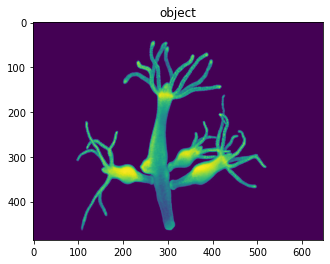

measurement shape: (486, 648)


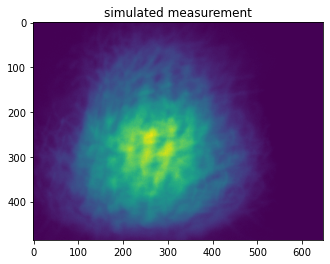

In [5]:
if data == 'real':
    meas = scipy.io.loadmat(real_path)
    meas = meas['b']
    
    plt.imshow(meas);
    plt.title('measurement');
    print('measurement shape:', meas.shape)

elif data == 'sim':
    im_in=imageio.imread(sim_path)
    im_in=np.sum(im_in,-1)/3
    im=cv2.resize(im_in,(weights.shape[1],weights.shape[0]))

    plt.imshow(im);
    plt.title('object');
    print('object shape:', im.shape)
    plt.show()
    
    # simulate data
    meas=fm.sim_data(im,H,weights,crop_indices)
    plt.imshow(meas);
    plt.title('simulated measurement');
    print('measurement shape:', meas.shape)
    
else:
    print('Error. Specify whether simulated or real data')

## Step 3: Initialize FISTA & place on GPU

In [9]:
# Place variables on GPU if using GPU
if device == 'GPU': 
    H = np.asarray(H)
    weights = np.asarray(weights)
    meas = np.asarray(meas)
    crop_indices = np.asarray(crop_indices)
    
H = H/np.max(H)    

# Initialize FISTA with H, weights, and crop indices 
fista = fista_svd(H, weights, crop_indices)

# Default: tv, Options: 'native' for native sparsity, 'non-neg' for enforcing non-negativity only
fista.iters = 500             
fista.prox_method = 'non-neg'  
fista.tv_lambda  = .0003    # tuning parameter for TV, larger is more TV
fista.tau = 0.003           # tuning parameter for native sparsity, larger is more sparse

## Step 4: Run SVD-FISTA reconstruction

iteration:  0  loss:  26310.557325769427


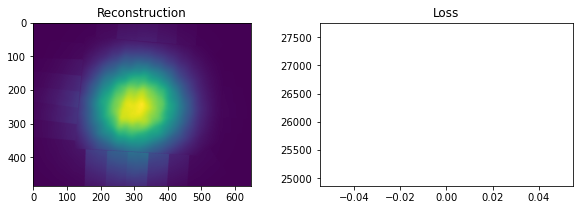

iteration:  20  loss:  224.4058111256608


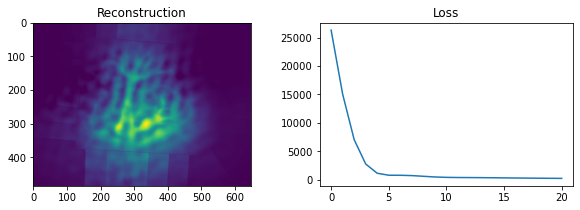

In [ ]:
out_img = fista.run(meas)